In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)
import caffe
import os

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
caffe.set_mode_cpu()

test_file = '../data_list/val_list.txt'
train_file = '../data_list/train_list.txt'
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    imList = []
    ratingList = []
    for l in lines:
        if len(l) > 2:
            l_split = l.split('.jpg ')
            #print l_split
            imList.append(l_split[0]+'.jpg')
            ratingList.append(float(l_split[1]))
    return imList,ratingList

testIm, testRating = readFile(test_file)
trainIm, trainRating = readFile(train_file)
imPath = testIm[10]
#imPath = caffe_root +'examples/images/fish-bike.jpg'
#lowest
#imPath = '/home/lli-ms/attractiveness_datamining/MIT2kFaceDataset/2kfaces/Google_1_Albert Makowski_6_oval.jpg'
#highest
imPath = '/home/lli-ms/attractiveness_datamining/MIT2kFaceDataset/2kfaces/Google_1_Nora Loeffler_7_oval.jpg'

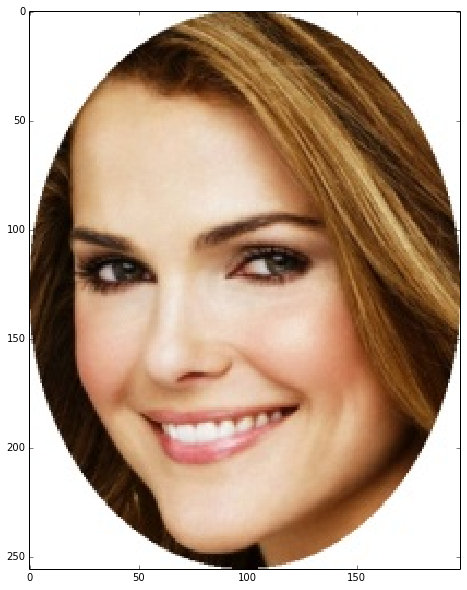

In [26]:
de_layers = ["conv1_1t","conv1_2t","conv2_1t","conv2_2t","conv3_1t","conv3_2t","conv3_3t"\
            ,"conv4_1t","conv4_2t","conv4_3t","conv5_1t","conv5_2t"]
co_layers = ["conv1_1","conv1_2","conv2_1","conv2_2","conv3_1","conv3_2","conv3_3"\
            ,"conv4_1","conv4_2","conv4_3","conv5_1","conv5_2"]
layerNum_list = ['1_1','1_2','2_1','2_2','3_1','3_2','3_3','4_1','4_2','4_3','5_1','5_2']
PRETRAINED_FILE ='/home/lli-ms/caffe/'+ 'models/vgg16_attr/snapshots/first_train_iter_2000.caffemodel'
#'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
#'models/vgg16_attr/snapshots/first_train_iter_2000.caffemodel'

import matplotlib.image as mpimg
im_orig = mpimg.imread(imPath)
plt.imshow(im_orig)
rec_size1 = [3,4,8,10,18,22,26,42,50,58,90,106]
rec_size = dict(zip(co_layers, rec_size1))
topfeaNum = 9
import math
axNum = int(math.sqrt(topfeaNum))
end_layer = 'fc_out'
saveFigPath = '../neuralNet/VGG16/filter_visual/'+'highest/'
if not os.path.exists(saveFigPath):
    os.makedirs(saveFigPath)

def crop_image(img,img2,tol,wind_size):
    s = img.shape[0]
    print img.shape
    inx = []
    iny = []
    for i in range(s):
        for j in range(s):
            if img[i,j,:].tolist()!= tol:
                inx.append(i)
                iny.append(j)
    mid_x = int((min(inx)+max(inx))/2.0)
    mid_y = int((min(iny)+max(iny))/2.0)
    x_min = max(0,mid_x-math.ceil(wind_size/2.0))
    x_max = min(s-1,mid_x+math.floor(wind_size/2.0))
    if x_min == 0 and (x_max - x_min)< wind_size:
        x_max  = x_min +wind_size
    if x_max == s-1 and (x_max - x_min)< wind_size:
        x_min = x_max -wind_size
    y_min = max(0,mid_y-math.ceil(wind_size/2.0))
    y_max = min(s-1,mid_y+math.floor(wind_size/2.0))
    if y_min == 0 and (y_max - y_min)< wind_size:
        y_max  = y_min +wind_size
    if y_max == s-1 and (y_max - y_min)< wind_size:
        y_min = y_max -wind_size
    return img[x_min:x_max,y_min:y_max,:],img2[x_min:x_max,y_min:y_max,:]

from collections import Counter
def find_color_gray(img):
    img_as_list = img.tolist()
    words_to_count = [str(word) for entries in img_as_list for word in entries ]
    c = Counter(words_to_count)
    str_common = c.most_common(1)[0][0]
    strs = str_common.replace('[','').replace(']','')
    lists = map(int, strs.split(','))
    return lists


*********************NOW PROCESSING LAYER 5_2**************************************
(512, 14, 14)
index before sort: [[341   6   7]]
top features:  [ 809.3180542]
(1,)
1
(224, 224, 3)
0.0
0.0
*********************DONE PROCESSING LAYER 5_2**************************************


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in divide


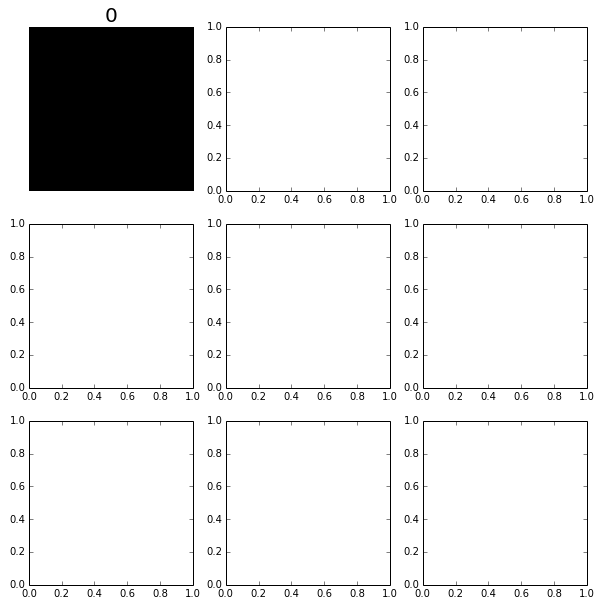

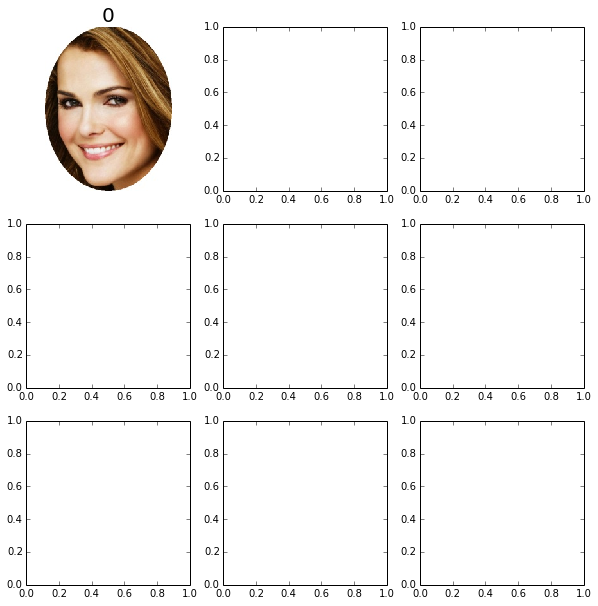

In [35]:
layer_num = '1_1'
topfeaNum = 1
for layer_num in [layerNum_list[-1]]:
    print '*********************NOW PROCESSING LAYER '+layer_num+'**************************************'
    MODEL_FILE = '../neuralNet/VGG16/vgg16_attr_deploy.prototxt'#attr_deconv_deploy'+layer_num+'.prototxt'
    net = caffe.Net(MODEL_FILE,
                    PRETRAINED_FILE,
                    caffe.TEST)

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(imPath))

    #deconv_layer = 'conv'+layer_num+'t'
    #copy_end = de_layers.index(deconv_layer)
    conv_layer = co_layers[copy_end]
#     for i in range(copy_end+1):
#         net.params[de_layers[i]][0].data[...] = net.params[co_layers[i]][0].data.transpose(0,1,3,2)

#     out = net.forward()
#     o = net.blobs['conv1_1t'].data[0].copy()
#     o -= o.min()
#     o /= o.max()
#     o *= 255
#     o = np.rollaxis(o, 0, 3).astype(np.uint8)
#     fig, ax = plt.subplots()
#     ax.imshow(o)
#     plt.show()
#     fig.savefig(saveFigPath+conv_layer+'_deconvOut.png')
    ## reconstruct from pool5
    # First find the top 9 activations of pool5, then zero out other activations
    # and then use one of several of the 9 activations to reconstruct an image
    oo = net.forward(end = end_layer)
    #print net.blobs[conv_layer].data[0].shape
    s = net.blobs[conv_layer].data[0].shape
    d = net.blobs[conv_layer].data[0].copy()
    print s
    # get the top 9 responsive filters, and record the index
    topInd = np.zeros((s[0],3))
    topResponse = np.zeros((s[0]))
    for fInd in range(s[0]):
        oneConv = d[fInd,:,:]
        oneConvShape = oneConv.shape
        oneConvSort = oneConv.reshape(oneConvShape[1]*oneConvShape[0])
        indices = np.argsort(oneConvSort)
        ind = indices[-1:] 
        topResponse[fInd] = oneConv[ind//(oneConvShape[1]),ind%(oneConvShape[1])%oneConvShape[0]]
        topInd[fInd] = [fInd,ind//(oneConvShape[1]),ind%(oneConvShape[1])%oneConvShape[0]]
    
    indices = np.argsort(topResponse)
    ind = indices[-topfeaNum:] 
    max_activationInd = topInd[ind,:].astype(int)
    print 'index before sort:', max_activationInd
    print 'top features: ', topResponse[ind]
    
#         ind = indices[-topfeaNum:] 
#         print 'index after sort:',indices[-topfeaNum:]
#         print 'index before sort:',[ind//(oneConvShape[1]),ind%(oneConvShape[1])%oneConvShape[0]]
#         print 'top features: ', oneConv[ind//(oneConvShape[1]),ind%(oneConvShape[1])%oneConvShape[0]]
    keep = net.blobs[conv_layer].data[0][max_activationInd[:,0],max_activationInd[:,1],max_activationInd[:,2]]
    print keep.shape
    
    f, axarr = plt.subplots(axNum, axNum)   
    f2, axarr2 = plt.subplots(axNum, axNum)
    for i in range(topfeaNum):
        net.blobs[conv_layer].data[...] = 0
        net.blobs[conv_layer].data[0][max_activationInd[i,0],max_activationInd[i,1],\
                                      max_activationInd[i,2]]=keep[topfeaNum - 1 - i]
        ii = net.blobs[conv_layer].data[0] != 0
        ii = ii.sum()
        print ii
        
        diffs = net.blobs[conv_layer].diff * 0
        diffs[0][max_activationInd[i]] = net.blobs[conv_layer].data[0][max_activationInd[i]]
        o = net.deconv_from_layer(conv_layer, diffs, zero_higher = True)['data'][0]
        o = o.transpose((2,1,0))
        print o.shape
    #diffs[0][backprop_unit] = net.blobs[deconv_layer].data[0,backprop_unit]
    #net.deconv_from_layer(backprop_layer, diffs, zero_higher = True)
    
#         out = net.forward(start=deconv_layer)
#     #     print net.blobs[deconv_layer].data[0].max()
#     #     print net.blobs[conv_layer].data[0].max()

#         o = net.blobs['conv1_1t'].data[0].copy()
        print o.min()
        print o.max()
        o -= o.min()
        o /= o.max()
        o *= 255
        o = o.astype(np.uint8)
        color_gray = find_color_gray(o)
        recep_size = rec_size[conv_layer]
#         im_crop, im_orig_crop = crop_image(o,im_orig,color_gray,recep_size)
#         print im_crop.shape
        ax1 = axarr[i/axNum,i%axNum]
        ax2 = axarr2[i/axNum,i%axNum]
        ax1.imshow(o)
        ax1.axis('off')
        ax1.set_title(str(i),fontsize = 20)
        ax2.imshow(im_orig)
        ax2.axis('off')
        ax2.set_title(str(i),fontsize = 20)
#     f.suptitle(conv_layer+' Top '+str(topfeaNum)+' Deconv Patches',fontsize = 20)
#     f2.suptitle(conv_layer+' Top '+str(topfeaNum)+' Original Image Patches',fontsize = 20)
#     f.savefig(saveFigPath+conv_layer+'_top'+str(topfeaNum)+'_deconv.png')
#     f2.savefig(saveFigPath+conv_layer+'_top'+str(topfeaNum)+'_original.png')
    print '*********************DONE PROCESSING LAYER '+layer_num+'**************************************'



In [ ]:
savePath = '../neuralNet/VGG16/filter_visual/'+'top9InTest/'
if not os.path.exists(savePath):
    os.makedirs(savePath)
layer_num = '4_3'
for layer_num in layerNum_list[5:]:
    print '*********************NOW PROCESSING LAYER '+layer_num+'**************************************'
    MODEL_FILE = '../neuralNet/VGG16/attr_deconv_deploy'+layer_num+'.prototxt'
    net = caffe.Net(MODEL_FILE,
                    PRETRAINED_FILE,
                    caffe.TEST)

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    deconv_layer = 'conv'+layer_num+'t'
    copy_end = de_layers.index(deconv_layer)
    conv_layer = co_layers[copy_end]
    for i in range(copy_end+1):
        net.params[de_layers[i]][0].data[...] = net.params[co_layers[i]][0].data.transpose(0,1,3,2)

    maxList = []
    for imPath in testIm:
        net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(imPath))
        oo = net.forward(end = end_layer)
        s = net.blobs[conv_layer].data[0].shape
        d = net.blobs[conv_layer].data[0].copy()
        d = d.reshape(s[1]*s[0]*s[2])
        indices = np.argsort(d)
        ind = indices[-topfeaNum:]
        #print indices[-topfeaNum:], net.blobs[conv_layer].data[0][ind//(s[1]*s[2]),(ind%(s[1]*s[2]))//s[1], ind%(s[1]*s[2])%s[1]]

        keep = net.blobs[conv_layer].data[0][ind//(s[1]*s[2]),\
                                          (ind%(s[1]*s[2]))//s[1],\
                                         ind%(s[1]*s[2])%s[1]]
        max_activation = keep[-1]
        maxList.append(max_activation)
    sortedIm = [x for (y,x) in sorted(zip(maxList,testIm))]
    sortedmax = [y for (y,x) in sorted(zip(maxList,testIm))]
    top_im = sortedIm[-topfeaNum:]

    f, axarr = plt.subplots(axNum, axNum)   
    f2, axarr2 = plt.subplots(axNum, axNum)
    for i in range(topfeaNum):
        imPath = top_im[topfeaNum-1-i]
        im_orig = mpimg.imread(imPath)
        #plt.imshow(im_orig)
        net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(imPath))
        oo = net.forward(end = end_layer)
        s = net.blobs[conv_layer].data[0].shape
        d = net.blobs[conv_layer].data[0].copy()
        d = d.reshape(s[1]*s[0]*s[2])
        indices = np.argsort(d)
        ind = indices[-topfeaNum:]
        #print indices[-topfeaNum:], net.blobs[conv_layer].data[0][ind//(s[1]*s[2]),(ind%(s[1]*s[2]))//s[1], ind%(s[1]*s[2])%s[1]]

        keep = net.blobs[conv_layer].data[0][ind//(s[1]*s[2]),\
                                          (ind%(s[1]*s[2]))//s[1],\
                                         ind%(s[1]*s[2])%s[1]] 
        net.blobs[conv_layer].data[...] = 0
        net.blobs[conv_layer].data[0][ind[-1]//(s[1]*s[2]),\
                                   (ind[-1]%(s[1]*s[2]))//s[1],\
                                   ind[-1]%(s[1]*s[2])%s[1]] = keep[-1]

        out = net.forward(start=deconv_layer)
        o = net.blobs['conv1_1t'].data[0].copy()
        o -= o.min()
        o /= o.max()
        o *= 255
        o = np.rollaxis(o, 0, 3).astype(np.uint8)
        color_gray = find_color_gray(o)
        recep_size = rec_size[conv_layer]
        im_crop, im_orig_crop = crop_image(o,im_orig,color_gray,recep_size)
        print im_crop.shape
        ax1 = axarr[i/axNum,i%axNum]
        ax2 = axarr2[i/axNum,i%axNum]
        ax1.imshow(im_crop)
        ax1.axis('off')
        ax1.set_title(str(i),fontsize = 20)
        ax2.imshow(im_orig_crop)
        ax2.axis('off')
        ax2.set_title(str(i),fontsize = 20)
    f.suptitle(conv_layer+' Top '+str(topfeaNum)+' Deconv Test Image Patches',fontsize = 20)
    f2.suptitle(conv_layer+' Top '+str(topfeaNum)+' Original Test Image Patches',fontsize = 20)
    f.savefig(savePath+conv_layer+'_top'+str(topfeaNum)+'_deconv.png')
    f2.savefig(savePath+conv_layer+'_top'+str(topfeaNum)+'_original.png')
    print '*********************DONE PROCESSING LAYER '+layer_num+'**************************************'

In [ ]:
test = net.forward()
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [11]:
conv_blobs = {pr: (net.blobs[pr].data[0]) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} outputs are {} dimensional '.format(conv, conv_blobs[conv].shape)

conv1_1 outputs are (64, 224, 224) dimensional 
conv1_2 outputs are (64, 224, 224) dimensional 
conv2_1 outputs are (128, 112, 112) dimensional 
conv2_2 outputs are (128, 112, 112) dimensional 
conv3_1 outputs are (256, 56, 56) dimensional 
conv3_2 outputs are (256, 56, 56) dimensional 
conv3_3 outputs are (256, 56, 56) dimensional 
conv4_1 outputs are (512, 28, 28) dimensional 
conv4_2 outputs are (512, 28, 28) dimensional 
conv4_3 outputs are (512, 28, 28) dimensional 
conv5_1 outputs are (512, 14, 14) dimensional 
conv5_2 outputs are (512, 14, 14) dimensional 
fc_pca outputs are (255,) dimensional 
fc_out outputs are (1,) dimensional 
conv5_2t outputs are (512, 14, 14) dimensional 
conv5_1t outputs are (512, 14, 14) dimensional 
conv4_3t outputs are (512, 28, 28) dimensional 
conv4_2t outputs are (512, 28, 28) dimensional 
conv4_1t outputs are (256, 28, 28) dimensional 
conv3_3t outputs are (256, 56, 56) dimensional 
conv3_2t outputs are (256, 56, 56) dimensional 
conv3_1t outputs a

(224, 224, 3)


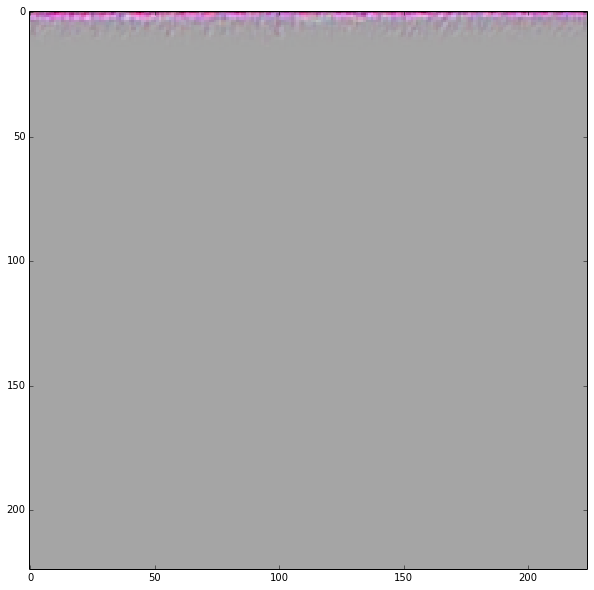

In [49]:
test = net.forward()

o = net.blobs['conv1_1t'].data[0]
o -= o.min()
o /= o.max()
o *= 255
o = np.rollaxis(o, 0, 3)
print o.shape
plt.imshow(o.astype(np.uint8))